## A Practical Diffusion Path for Sampling

In this notebook, we will reproduce the experiment made by Anna Korba and O. Chebab in the article: "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)", 2024.

The main goal is to draw samples from complex target distribution. (...) On s'occupe de la rédaction ensuite car fle


In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *


### I. Sampling a Gaussian Mixture with 16 modes

We will compare 3 methods to sample a target distribution which is a Gaussian Mixture with 16 modes : 
- Unadjusted Langevin Algorithm (ULA)
- ULA with geometric path 
- ULA with dilation path

We consider that sample from the target distribution are not available, which make the task of using diffusion models more complicated (except for the dilation path). 

Convergence metrics (aims to quantify the distance between intermediaries distributions and the target distribution) : DEFINE THEM
- KSD
- KL
- MMS

Parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)

------------------------------------------------------------------------------------------------------------------------------------------------------
We start by the first example of the paper, the settings are given here : 

In [2]:
#We define the grid

x = np.linspace(-15, 15, 4)
y = np.linspace(-15, 15, 4)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances = np.array([[[3, 0], [0, 3]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

We consider that we have access to the gradient of the score of the target distribution, which means that we can implement the ULA. 

We know that the score vector for a $ \mathcal{N}(\mu, \Sigma) $ is given by : 

$ \nabla \log p(x) = \Sigma^{-1}(x- \mu) $ 

As, a Multimodal Normal Distribution as a density that can be written as a weighted sum of $\mathcal{k}$ densities Multivariate Normal : 

$ f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

where :

- $ (w_i)_{i:n} $ is the vector of weights of the $\mathcal{k}$ normal distributions 
- $\mathcal{N}(x \mid \mu_i, \Sigma_i) $ is the density of the i^th normal distribution which composes the multimodal
- $\sum_{i=1}^{k} w_i = 1 $, guarantees that the function is a density




------------------------------------------------------------------------------------------------------------------------------------------------------
Function to generate a graph of 2-dimensionnal Gaussian Mixture Distribution

In [3]:
evaluate_gaussian_mixture(np.array([0]), np.array([1]), np.array([0]), np.array([1]))

0.3989422804014327

#### Gradient of the score of a multimodal : 

$ \nabla \log f(x)$ is computed as follow : 

$ \nabla \log f(x) = \sum_{i=1}^{k} \frac{w_i}{f(x)} \cdot \Sigma_i^{-1} (x - \mu_i) \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

Where :
- $ f(x) $ is the density of the multimodal distribution

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function which computes to score vector of a Gaussian Mixture distribution given its parameters : 

In [4]:
grad_multimodal_opti(np.array([[1,1], [2, 2], [3, 3]]), weights, centers, covariances)

array([[1.21851601, 1.21851601],
       [0.99576328, 0.99576328],
       [0.66651534, 0.66651534]])

### Unadjusted Langevin Algorithm

Description of the idea : Blabla

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function for the Unadjusted Langevin Algorithm given : 
- The initial position of the particle $ x_o $ (in our case drawn from a standard Gaussian distribution)
- The parameters of the gaussian mixture (just used to compute the score vector because we consider that we cannot have access to samples of the target distribution)
- The number of iterations until we stop the algorithm
- The step size (considered constant here because "Unadjusted")

Definition of the parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)
- Linear Schedule : $ \forall \mathbb{t} \in \mathbb{R^+} , \lambda_t = \min(1, \mathbb{t}) $


100%|██████████| 10000/10000 [01:30<00:00, 110.78it/s]


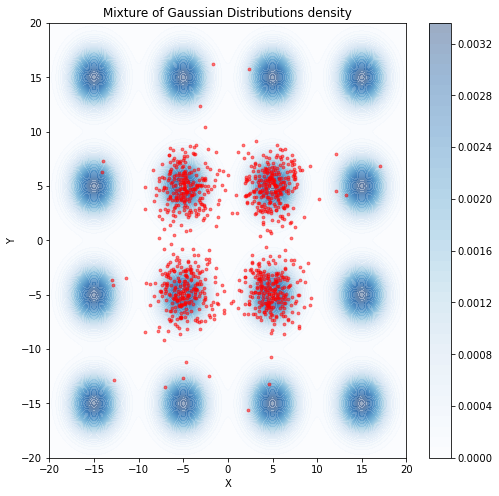

'The magnitude of the Stochastic term is 0.056039367616418694 whereas the magnitude of the gradient term is 0.0008581448924233622'

In [10]:
sample_init = np.random.randn(1000, 2)
ULA(sample_init, 10000, 0.001, weights, centers, covariances)

### Dilation Path

Description de la technique : 

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function for the Unadjusted Langevin Algorithm, with Dilation Path. It means that we apply the same equation to update the position of each particle (not-stochastic, constant step size, ...), but with intermediate distributions. 

The parameters of the algo : 
- The initial position of the particle $ x_o $ (in our case drawn ...)
- The parameters of the gaussian mixture (just used to compute the score vector because we consider that we cannot have access to samples of the target distribution and we can apply the algo by just being able to compute a score vector)
- The number of iterations until we stop the algorithm
- The step size (considered constant here because "Unadjusted")

We keep the same parameters than the previous case (ULA), except for the initialisation that we manually set as $ x_0 = (0,0)$ (question about it)


  0%|          | 3/10000 [00:00<06:00, 27.70it/s]

100%|██████████| 10000/10000 [02:06<00:00, 79.09it/s]


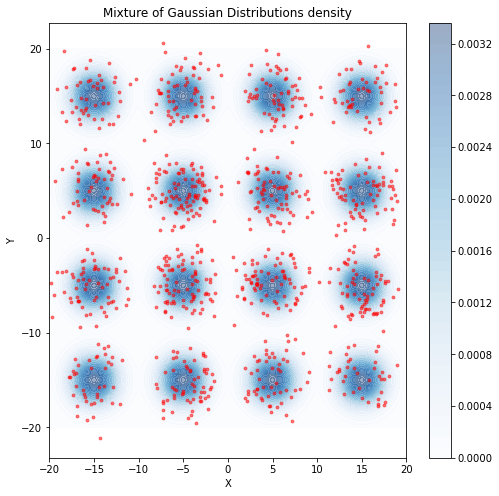

The magnitude of the Stochastic term is 0.286643696009927 whereas the magnitude of the gradient term is 0.019999841823680534


' Voici le step moyen sur toutes les particles 0.028434408046395177, et voici le time moyen auquel on est sur la simu 284.3440804639518'

In [6]:
sample_init = np.random.randn(1000, 2)
ULA_dilation(sample_init, 10000, 0.02, weights, centers, covariances, 1, alpha = 0.02) #1 schedule

------------------------------------------------------------------------------------------------------------------------------------------------------
Experiment with farer modes : The results are clearer because the ULA takes and exponential time (function of the distance between the modes) to reach a new mode 

100%|██████████| 20000/20000 [03:24<00:00, 97.98it/s] 


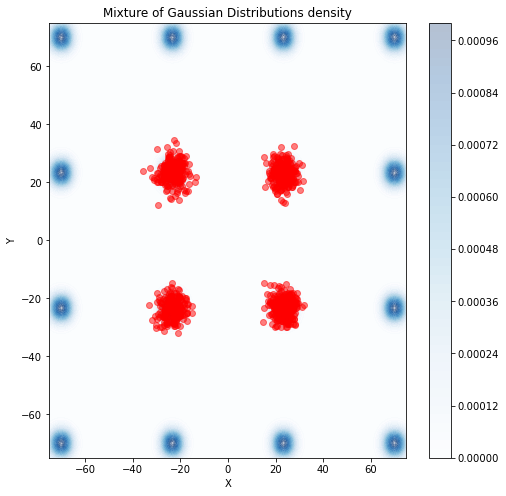

Temps d'exécution pour plot le graph est: 1.908160924911499 secondes


'The magnitude of the Stochastic term is 0.17724648710174917 whereas the magnitude of the gradient term is 0.005029482255721319'

In [526]:
sample_init = np.random.randn(1000, 2)
ULA(sample_init, 20000, 0.01, weights, centers, covariances)

Geometric Path 

100%|██████████| 2000/2000 [00:24<00:00, 82.60it/s] 


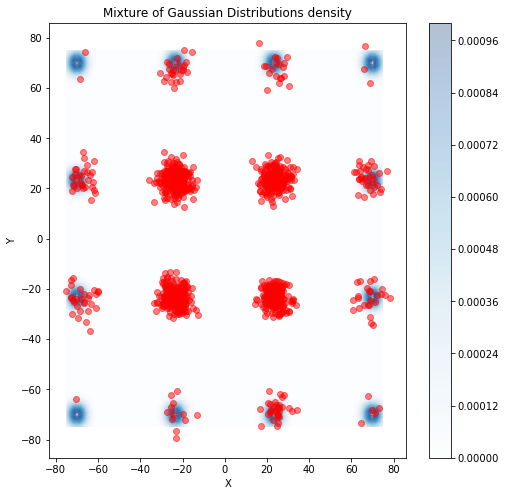

Temps d'exécution pour plot le graph est: 2.0963048934936523 secondes
The magnitude of the Stochastic term is 0.17723776894804616 whereas the magnitude of the gradient term is 0.026085004024898304


' Voici le step moyen sur toutes les particles 0.010000000000000163, et voici le time moyen auquel on est sur la simu 20.000000000000334'

In [573]:
sample_init = np.random.randn(1000, 2)
ULA_geometric(sample_init, weights, centers, covariances, 0.01, 20000)

Dilation path with a linear schedule : 

  0%|          | 0/20000 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_40765/681934052.py:32: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_40765/681934052.py:32: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 20000/20000 [02:21<00:00, 141.16it/s]


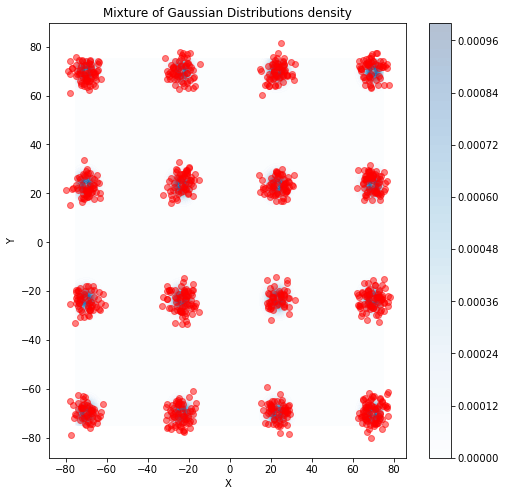

Temps d'exécution pour plot le graph est: 0.9533529281616211 secondes
The magnitude of the Stochastic term is nan whereas the magnitude of the gradient term is nan


' Voici le step moyen sur toutes les particles nan, et voici le time moyen auquel on est sur la simu nan'

In [528]:
ULA_dilation(sample_init, 20000, 0.02, weights, centers, covariances, alpha = 0.01)

### ULA with geometric path

Description : 

------------------------------------------------------------------------------------------------------------------------------------------------------
As previously, we define a function to run the ULA, with geometric path for one particle. We also define the function to plot the result and we have the same parameters as previously

Schedule jusqu'à T = 3

100%|██████████| 10000/10000 [01:17<00:00, 128.27it/s]


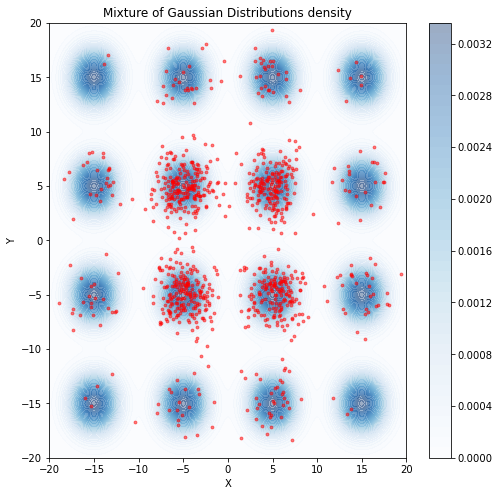

The magnitude of the Stochastic term is 0.0560468127326337 whereas the magnitude of the gradient term is 0.001194071129035955


' Voici le step moyen sur toutes les particles 0.00099999999999999, et voici le time moyen auquel on est sur la simu 9.999999999999899'

In [9]:
sample_init = np.random.randn(1000, 2)
ULA_geometric(sample_init, weights, centers, covariances, 0.001, 10000, 3)

Schedule jusuq'à 5

100%|██████████| 10000/10000 [01:33<00:00, 106.84it/s]


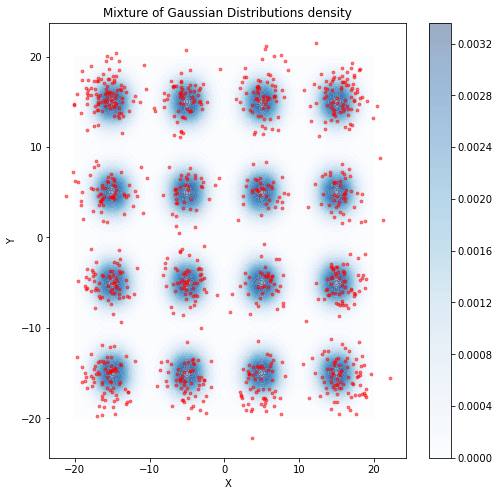

The magnitude of the Stochastic term is 0.056047980336215684 whereas the magnitude of the gradient term is 0.0025545164399375627


' Voici le step moyen sur toutes les particles 0.00099999999999999, et voici le time moyen auquel on est sur la simu 9.999999999999899'

In [8]:
sample_init = np.random.randn(1000, 2)
ULA_geometric(sample_init, weights, centers, covariances, 0.001, 10000, 5)

------------------------------------------------------------------------------------------------------------------------------------------------------
Let's plot the same graphs as in the article :

20,000 iterations and 20 particles

In [44]:
x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

nb_particles = 20

xx, yy = np.meshgrid(x, y)

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix
covariances = np.array([[[10, 0], [0, 10]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16

# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)
sample_init = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], nb_particles)

### II. 40-modes Gaussian Mixture

In this part, we will reproduce the second part of the experiment. All the parameters of the experiement are the same as previously except the parameters of the target distribution : 40 modes and the no longer equally-weighted and the step is 0.01 to have a faster convergence (10 times more than in the article a priori)

In [47]:
## Let's set the parameters of the new target : 

weights = np.random.uniform(0, 1, 40)
weights = weights / np.sum(weights)

centers = np.random.uniform(-50, 50, (40, 2))

covariances = np.array([[10, 0], [0, 10]] * 40).reshape((40, 2, 2)) #10*I_2 pour chaque composante de la Mixture

sample_init = np.random.randn(1000, 2)

100%|██████████| 10000/10000 [06:30<00:00, 25.62it/s]


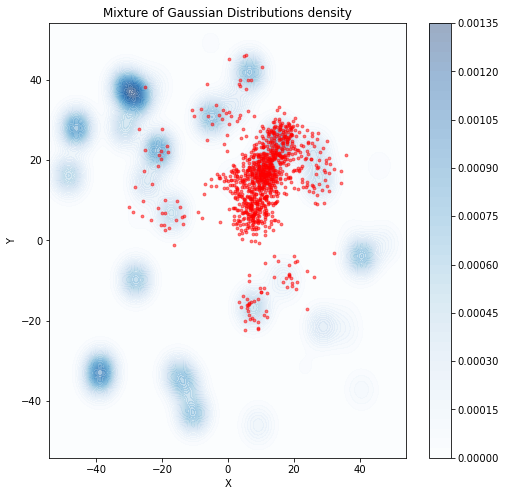

'The magnitude of the Stochastic term is 0.17717866350368608 whereas the magnitude of the gradient term is 0.0036394697980765356'

In [ ]:
ULA(sample_init, 10000, 0.01, weights, centers, covariances)

  0%|          | 13/10000 [00:00<02:40, 62.41it/s]

100%|██████████| 10000/10000 [02:18<00:00, 72.38it/s]


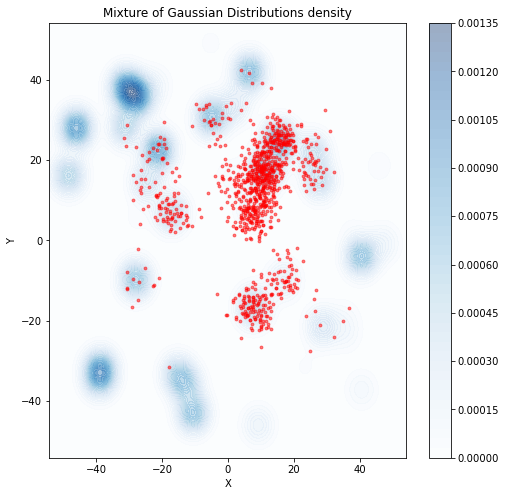

The magnitude of the Stochastic term is 0.1772423566925695 whereas the magnitude of the gradient term is 0.0038552511181783717


' Voici le step moyen sur toutes les particles 0.010000000000001426, et voici le time moyen auquel on est sur la simu 100.00000000001427'

In [ ]:
ULA_geometric(sample_init, weights, centers, covariances, 0.01, 10000, 2)

100%|██████████| 10000/10000 [02:36<00:00, 63.73it/s]


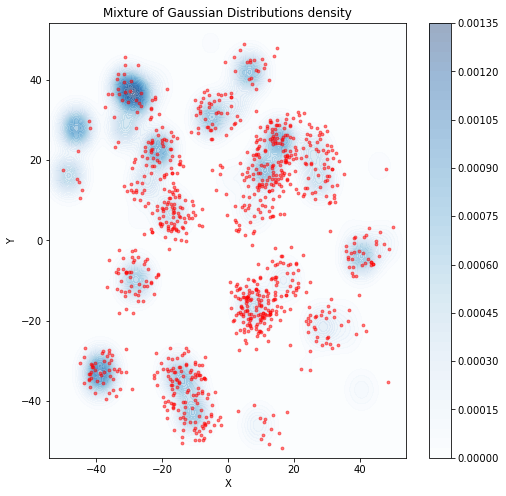

The magnitude of the Stochastic term is 0.2331520939736257 whereas the magnitude of the gradient term is 0.009999795010512213


' Voici le step moyen sur toutes les particles 0.0208877299279505, et voici le time moyen auquel on est sur la simu 208.87729927950497'

In [ ]:
ULA_dilation(sample_init, 10000, 0.05, weights, centers, covariances, 100, alpha = 0.01)

### Statistical divergences used for evaluation

In this section we define different convergence metrics to measure the discrepancy between the target distribution $\pi$ and the intermediate distributions $\mu_t$ that we use at each iteration. For this we will use an approximation of several statistical divergences, built from samples of the target distribution $\pi$ and from each intermediate distribution. 

------------------------------------------------------------------------------------------------------------------------------------------------------
First, let's define the Kernel Stein Discrepancy (KSD), defined as : 

$ \text{KSD}^2(p_k, \pi) = \mathbb{E}_{(x, x') \sim p_k \otimes p_k} [K(x, x'; \pi, K')] $

where : 
- $K(.)$ is a Kernel that requires the unormalized target distribution and another Kernel $K'(.)$ 

It is defined as : 

$ K(x, y; \pi, K') = \nabla \log \pi(x)^T \nabla \log \pi(y) K'(x, y) + \nabla \log \pi(x)^T \nabla_y K'(x, y) + \nabla_x K'(x, y)^T \nabla \log \pi(y) + \nabla_x \cdot \nabla_y K'(x, y) $

- $K'(.)$ is the Inverse Multiquadratic Kernel, defined as : 

$ K'(x, y) = (1 + \|x - y\|^2)^{-\beta} \quad \text{where} \ \beta \in [0, 1] \ \text{and is here chosen as} \ 0.5 $

We define both Kernels and then a function that takes as arguments the parameters of the target distribution (Gaussian Mixture) and a sample from the intermediate distribution (whose items are consider independant)



In [34]:
multiquad_kernel(np.array([1,0]), np.array([2,2]), -2)

36

To compute the second kernel value, we need to compute the gradients of the Multiquadratic Kernel w.r.t $x$ and $y$, given by : 

- $ \nabla_x K'(x, y) = -2 \beta (1 + \|x - y\|^2)^{-\beta-1} (x - y) $  
- $\nabla_y K'(x, y) = 2 \beta (1 + \|x - y\|^2)^{-\beta-1} (x - y)$


In [36]:
grad_multiquad_kern(np.array([1,0]), np.array([2,2]))

[array([0.06804138, 0.13608276]), array([-0.06804138, -0.13608276])]

In [42]:
compute_kernel(np.array([1,0]), np.array([2,2]), weights, centers, covariances, beta = 0.5)

-0.03632778332938214

In [79]:
intermediate_sample = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0], [0,1]]), 10).reshape(10, 2)

In [80]:
squared_KSD(intermediate_sample, weights, centers, covariances, beta = 0.5)

<class 'int'>


100%|██████████| 5/5 [00:00<00:00, 32.24it/s]


-0.10784803113984484

Calculs précédents à vérifier

------------------------------------------------------------------------------------------------------------------------------------------------------
We define the Kullbach-Leibler divergence between two distributions, given by : 

$ \text{KL}(p_k, \pi) = \mathbb{E}_{x \sim p_k} \left[ \log \frac{p_k(x)}{\pi(x)} \right] $

We can have the rev-KL by switching the roles of $p_k$ and $\pi$ 

Est-ce qu'on peut même le coder sans coder la log densité de $p_k$ ????????


Example of how to use the scipy KL : 

In [87]:
P = [0.3, 0.5, 0.2]   # Distribution P
Q = [0.2, 0.6, 0.2]   # Distribution Q

# Calcul de la KL divergence de P par rapport à Q
kl_divergence = entropy(pk=P, qk=Q)
kl_divergence

0.03047875403547197

Same with the Wasserstein Distance : 

We skip Maximum Mean Discrepancy (MMD) 

We define the Multimodality Score (MMS) : 

Est ce que l'expected particle by mode c'est bien les poids ? 

In [96]:
MMS([0,0], weights, centers)

100%|██████████| 2/2 [00:00<00:00, 167.29it/s]


0.4881406047441659